In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pyro
import pyro.distributions
import torch
from torch.distributions import constraints

az.style.use("arviz-doc")

# import arviz

/home/carstenj/miniconda3/envs/pml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class CustomDensity(pyro.distributions.TorchDistribution):
    # The domain of the custom PDF
    support = constraints.interval(torch.tensor(-3), torch.tensor(3))
    # Enforce that start value is within the support
    arg_constraints = {"start": support}

    def __init__(self, start=torch.tensor(0.0)):
        self.start = start
        super(pyro.distributions.TorchDistribution, self).__init__()

    def sample(self, sample_shape=torch.Size()):
        return self.start

    def log_prob(self, x):
        # Return log of the unnormalized density
        return -(x**2) / 2 + torch.log(
            (
                (torch.sin(x)) ** 2
                + 3 * (torch.cos(x)) ** 2 * (torch.sin(7 * x)) ** 2
                + 1
            )
        )

In [3]:
# Specify the model, which in our case is just our MyDensity distribution
def model():
    x = pyro.sample("x", CustomDensity())

In [ ]:
# Run HMC / NUTS

# Initial parameters for each chain
# initial_params = {
#     "x": torch.tensor([-2.0, 2.0, -1.0, 1.0])  # Shape [num_chains]
# }

nuts_kernel = pyro.infer.NUTS(model)
mcmc = pyro.infer.MCMC(
    nuts_kernel,
    num_samples=10,
    num_chains=1,
    warmup_steps=500,
    # initial_params=initial_params,
)
mcmc.run()

Sample: 100%|██████████| 2000/2000 [00:19, 101.10it/s, step size=2.79e-01, acc. prob=0.706]


In [5]:
# Get the samples
samples = mcmc.get_samples()["x"]

# Calculate E(x^2)
print(torch.mean(samples**2).item())

1.0652682781219482


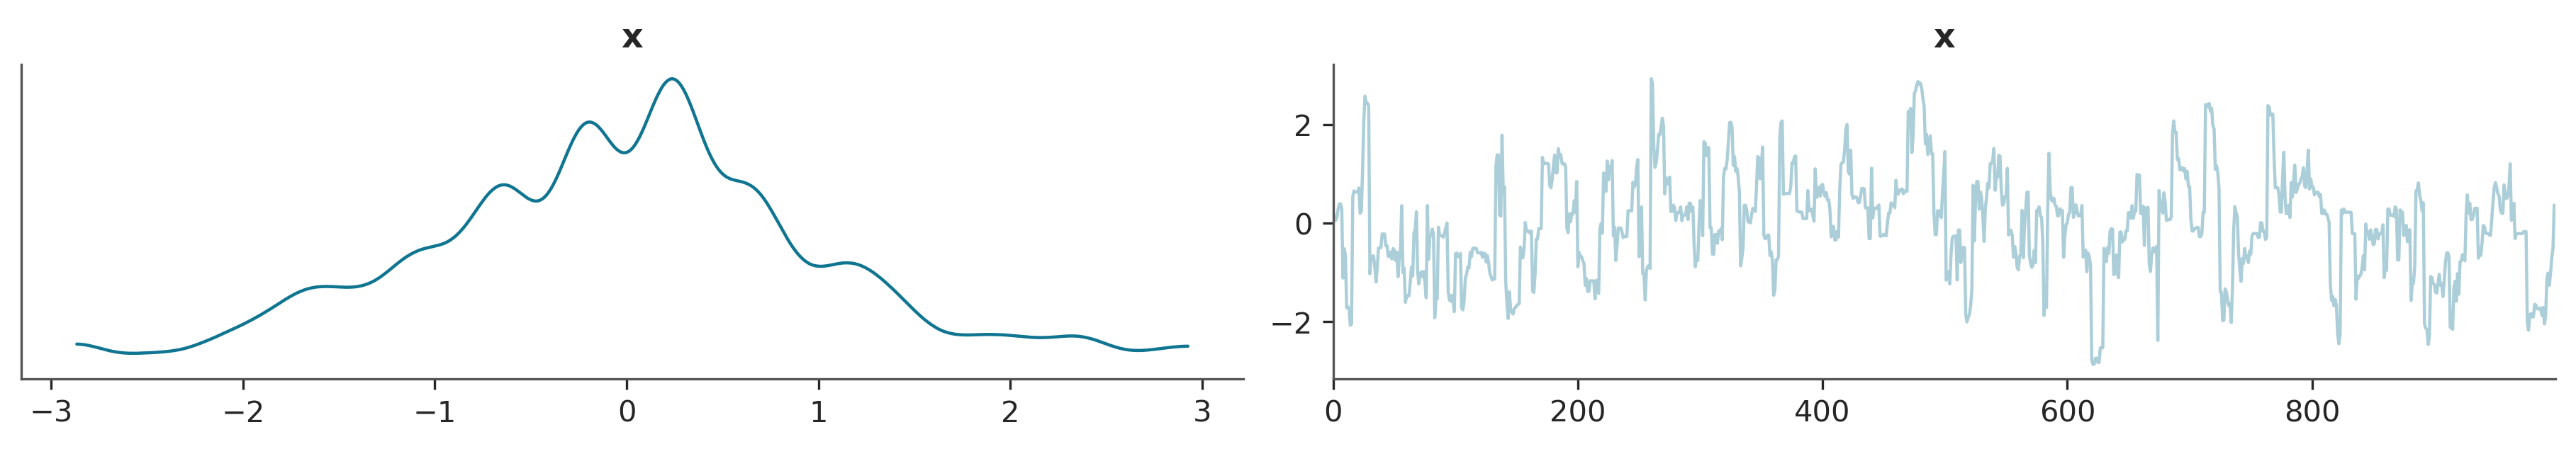

In [ ]:
# TODO use arviz to summarize and investigate: plot
data = az.from_pyro(mcmc)

az.plot_trace(data, var_names=("x"))

plt.show()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -0.032  1.032  -2.177    1.844       0.13    0.092      62.0     147.0   

   r_hat  
x    NaN  


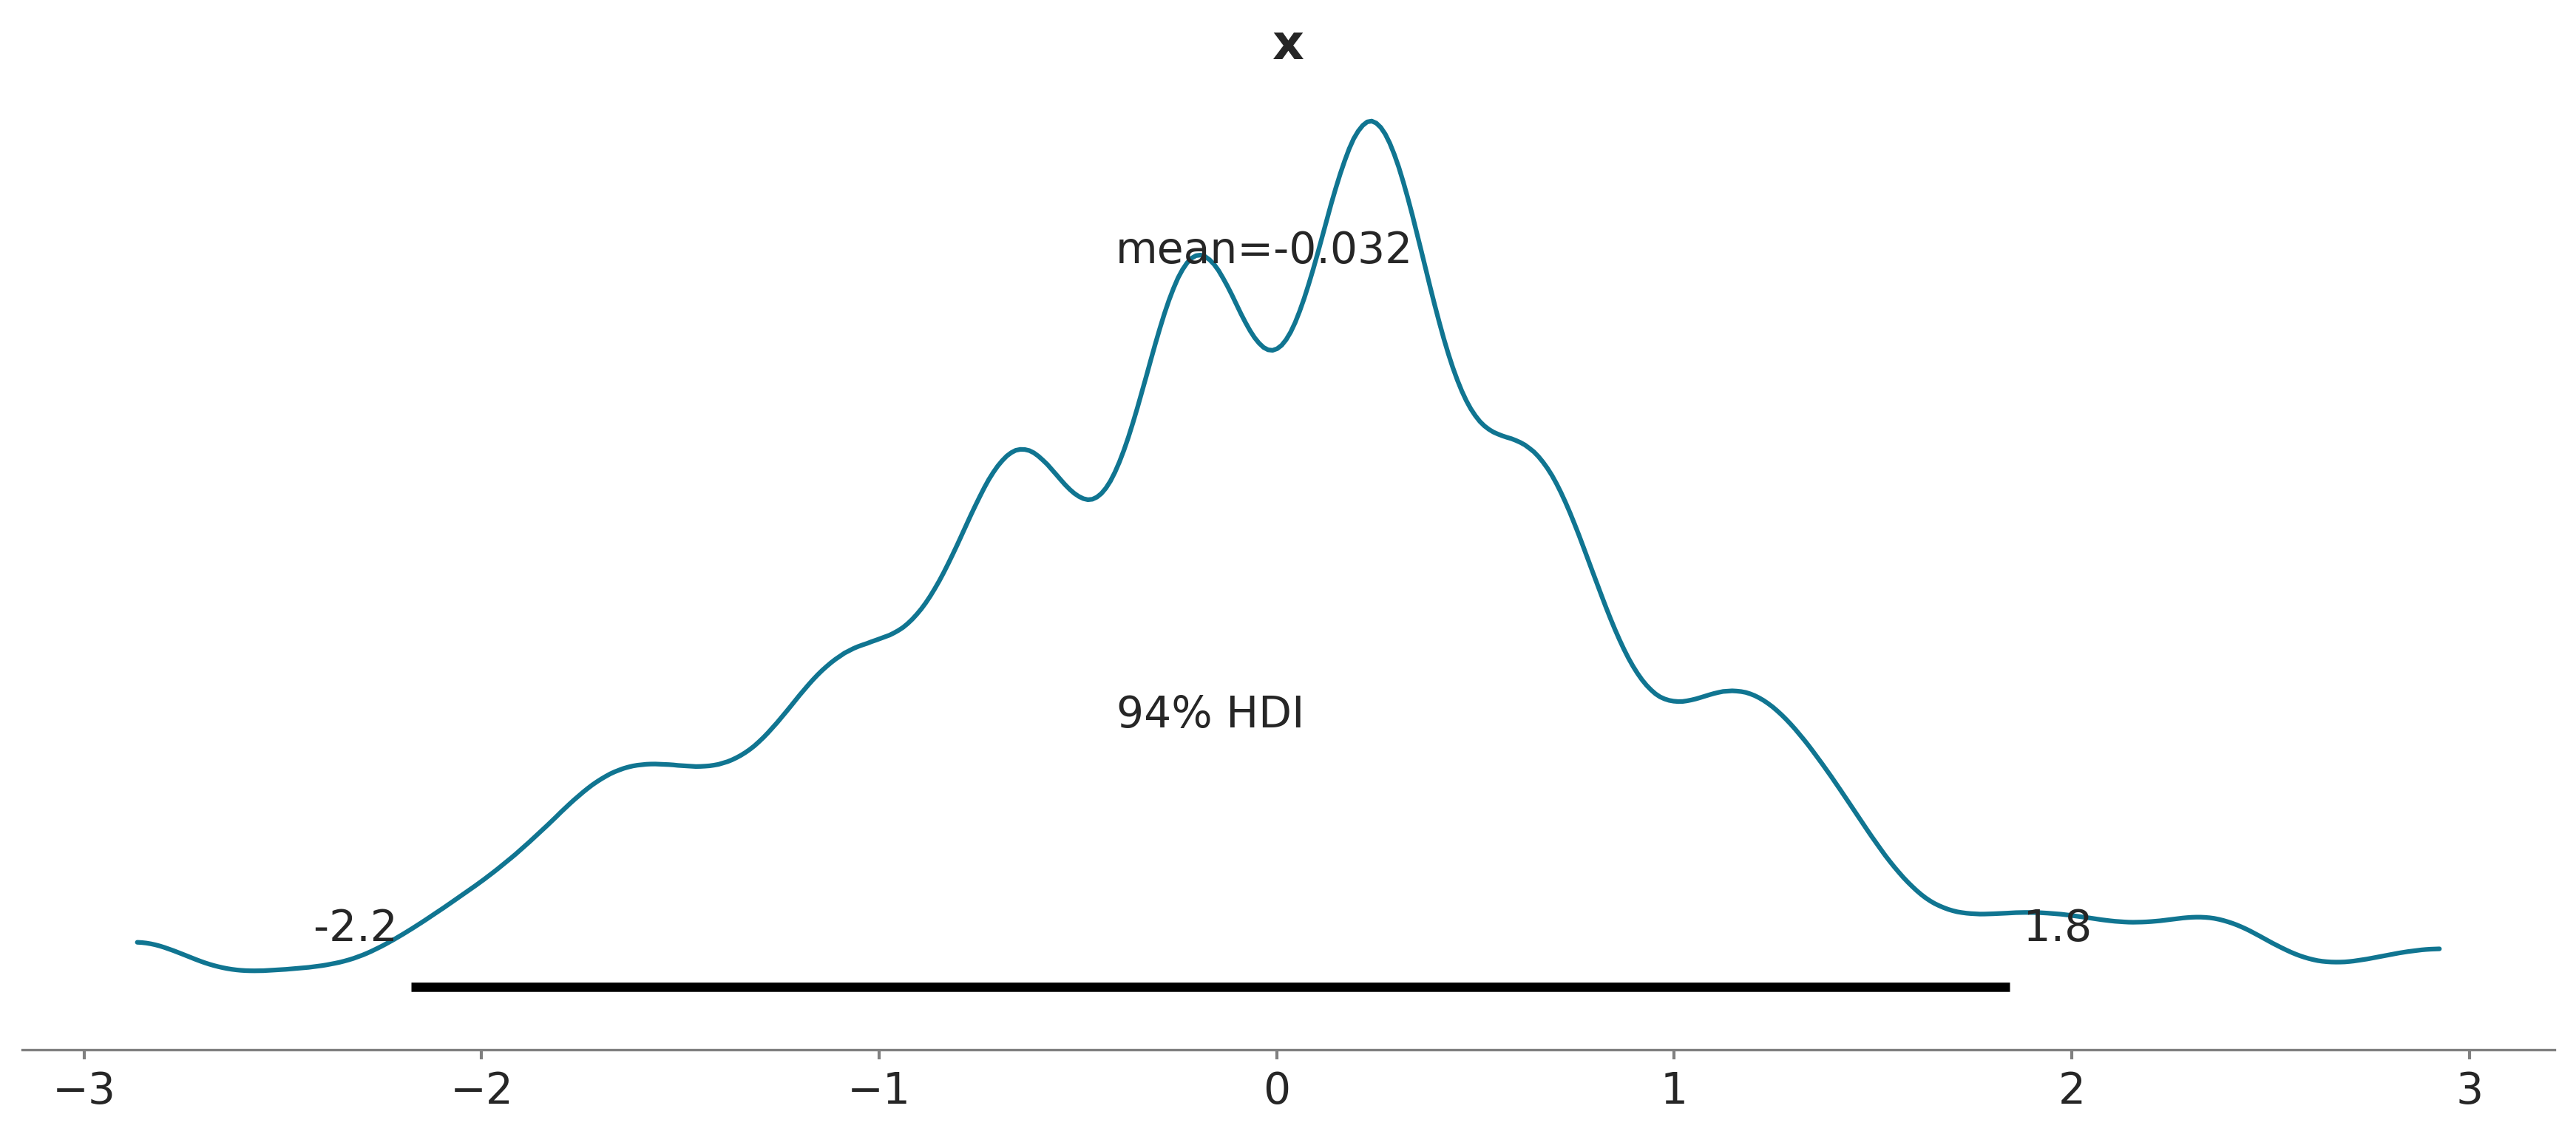

In [7]:
data = az.from_pyro(mcmc)
# ESS, r-hat
summary = az.summary(data)
print(summary)
# Density plot
az.plot_posterior(data)
plt.show()

In [ ]:
# HMC / NUTS
def HMC(n_samples):
    # Run HMC / NUTS
    nuts_kernel = pyro.infer.NUTS(model)
    mcmc = pyro.infer.MCMC(
        nuts_kernel,
        num_samples=n_samples,
        num_chains=1,
        warmup_steps=1000,
        # initial_params=initial_params,
    )
    # Do something with the mcmc object here ...
    mcmc.run()

    # TODO Get the samples
    samples = mcmc.get_samples()["x"]

    # TODO: Calculate E(x^2)
    expected_val = torch.mean(samples**2).item()
    return expected_val

In [ ]:
# TODO make figures w.r.t. different sample sizes, samplers, etc.